In [97]:
from google.oauth2 import service_account
from google.cloud import storage
import io
import nibabel as nib
import os
import pandas as pd
import tensorflow as tf
import gcsfs
import random
import re
from nilearn import image
import numpy as np
import time
import matplotlib.pyplot as plt

rel_path = '../data/'

In [2]:
#first create this file via IAM management on Google Cloud Platform
#change path
api_key = "deep-learning-255016-4350337ed6f4.json"
credentials = service_account.Credentials.from_service_account_file(api_key)
client = storage.Client(credentials=credentials, project="deep-learning")

fs = gcsfs.GCSFileSystem(token=api_key, project="deep-learning")
with fs.open('mri_data_bucket/ADNI_t1_list_with_fsstatus_20190111.csv') as f:
    df = pd.read_csv(f)
df.to_csv('labels.csv')

In [113]:
bucket_name = "mri_data_bucket"
bucket = client.get_bucket(bucket_name)
prefix = "data"
blobs = bucket.list_blobs(prefix=prefix)

file_names = [blob.name for blob in blobs]

In [68]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [69]:
labels=df[['Subject','T1.SERIESID','Group']].copy()

def labels_slice(labels, groups):
    
    filter_ = pd.Series(np.repeat(0, labels.shape[0]), index=labels.index)
    for group in groups:
        group_filter = (labels.Group == group)
        filter_ = filter_ | group_filter
    labels = labels[pd.Series(filter_)]
    return labels

labels = labels_slice(labels, ['CN', 'AD', 'EMCI', 'LMCI', 'MCI'])



labels['new_ind']=labels['Subject']+"_"+labels['T1.SERIESID'].astype(str)
labels.loc[labels.Group == 'CN','Group']=0
labels.loc[labels.Group == 'AD','Group']=1
labels.loc[labels.Group == 'EMCI','Group']=2
labels.loc[labels.Group == 'LMCI','Group']=3
labels.loc[labels.Group == 'MCI','Group']=4
labels = labels.set_index('new_ind')
labels=labels.drop(columns=['Subject','T1.SERIESID'])

In [70]:
print("Number of images: ", len(file_names))
print("Number of images without label: ", len(file_names) - labels.shape[0])
print("Labels: ", labels.shape[0])

Number of images:  10435
Number of images without label:  787
Labels:  9648


In [71]:
pattern1 = re.compile(r'S\d+')
pattern2 = re.compile(r'\d+_S_\d+')

In [72]:
def download(file_names, path='../data'):
    """
    run only 1 time to transfer the data from the bucket to the path
    transfers only data with label
    """
    if not os.path.exists(path):
        os.makedirs(path)
    count=0
    with_label = []
    for filename in file_names:
        filename=filename[5:]
        try:
            series_id = re.search(pattern1, filename).group(0)[1:]
            subject = re.search(pattern2,filename).group(0)
            ind=subject+"_"+series_id
        
            label=labels.loc[ind,'Group']          
            blob = bucket.blob('data/'+filename)
            blob.download_to_filename(path + filename)
            count+=1

            if count % 500 ==0:
                print(count)
        except:
            continue
    print('Total files downloaded: ', count)
#download(file_names, path=rel_path)

In [73]:
with_label = [i for i in file_names if (
    re.search(pattern2, i[5:]).group(0)+"_"+re.search(pattern1, i[5:]).group(0)[1:] in labels.index)]

ids = [re.search(pattern2, i[5:]).group(0)+"_"+re.search(pattern1, i[5:]).group(0)[1:] for i in file_names]

label_with_no_image = [i for i in labels.index if i not in ids]
print('Number of pictures with labels but no features: ', len(label_with_no_image))

Number of pictures with labels but no features:  83


In [74]:
buffer = []
two_image_same_id = []
count = 0
for i in file_names:
    ind = re.search(pattern2, i[5:]).group(0)+"_"+re.search(pattern1, i[5:]).group(0)[1:] 
    if (ind in labels.index) and (ind in buffer):
        two_image_same_id.append(ind)
        count +=1
    buffer.append(ind)
print('Pictures that have the same ID but different files: ', len(two_image_same_id))

Pictures that have the same ID but different files:  84


In [75]:
# TWO IMAGES ONE LABEL. BOTH GET DOWNLOADED 
example = "002_S_1261_101646"
print("Example of two files with same ID")
for i in file_names:
    ind = re.search(pattern2, i[5:]).group(0)+"_"+re.search(pattern1, i[5:]).group(0)[1:] 
    if ind == example:
        print(ind, i)


Example of two files with same ID
002_S_1261_101646 data/002_S_1261-S101646-T_T1_brain_mni305.nii
002_S_1261_101646 data/002_S_1261_S101646_T1_brain_mni305.nii


In [76]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Located at: ", get_available_gpus())

Num GPUs Available:  1
Located at:  ['/device:GPU:0']


In [77]:
with_label = np.asarray([name[5:] for name in with_label])
#with_label = with_label[:200]

In [17]:
def normalise_GPU(file_names):
    count = 0
    start_time = time.time()
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        min_x=tf.ones(256**3)*np.inf
        max_x=tf.zeros(256**3)
        for filename in file_names:

            image_ = nib.load(rel_path + filename)
            image = image_.get_data()
            x = tf.reshape(image, [-1])
            min_x = tf.minimum(min_x, x)           
            max_x = tf.maximum(max_x, x)
            count += 1
            if count % 200 == 0:
                print("--- {:.1f} seconds ---".format(time.time() - start_time))
                print(count)
                start_time = time.time()
    return min_x, max_x

#min_, max_ = normalise_GPU(with_label)

--- 86.195 seconds ---
100
--- 80.236 seconds ---
200
--- 79.895 seconds ---
300
--- 80.716 seconds ---
400
--- 79.880 seconds ---
500
--- 80.396 seconds ---
600
--- 80.641 seconds ---
700
--- 80.824 seconds ---
800
--- 79.659 seconds ---
900
--- 81.631 seconds ---
1000
--- 79.346 seconds ---
1100
--- 80.456 seconds ---
1200
--- 81.188 seconds ---
1300
--- 81.451 seconds ---
1400
--- 81.946 seconds ---
1500
--- 81.286 seconds ---
1600
--- 81.941 seconds ---
1700
--- 82.126 seconds ---
1800
--- 82.862 seconds ---
1900
--- 81.197 seconds ---
2000
--- 79.340 seconds ---
2100
--- 79.693 seconds ---
2200
--- 81.068 seconds ---
2300
--- 79.629 seconds ---
2400
--- 80.170 seconds ---
2500
--- 78.943 seconds ---
2600
--- 79.710 seconds ---
2700
--- 82.454 seconds ---
2800
--- 87.024 seconds ---
2900
--- 84.882 seconds ---
3000
--- 87.953 seconds ---
3100
--- 88.712 seconds ---
3200
--- 89.543 seconds ---
3300
--- 89.013 seconds ---
3400
--- 88.430 seconds ---
3500
--- 87.120 seconds ---
3600
-

In [136]:
def normalise_XYZ_GPU(file_names, x_=127, y_=127, z_=127):
    count=0
    start_time = time.time()
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        min_x, min_y, min_z = tf.ones(156**2)*np.inf, tf.ones(156**2)*np.inf, tf.ones(156**2)*np.inf
        max_x, max_y, max_z = tf.zeros(156**2), tf.zeros(156**2), tf.zeros(156**2)
    
        for filename in file_names:

            image_ = nib.load(rel_path+filename)
            image = image_.get_data()
            x = image[x_,50:206,50:206]
            x = tf.reshape(x, [-1])
          
            y = image[50:206,y_,50:206]
            y = tf.reshape(y, [-1])
          
            z = image[50:206,50:206,z_]
            z = tf.reshape(z, [-1])
                     
            min_x = tf.minimum(min_x, x)
            min_y = tf.minimum(min_y, y)
            min_z = tf.minimum(min_z, z)
          
            max_x = tf.maximum(max_x, x)
            max_y = tf.maximum(max_y, y)
            max_z = tf.maximum(max_z, z)
            count+=1
            if count % 200 == 0:
                print("--- {:.1f} seconds ---".format(time.time() - start_time))
                print(count)
                start_time = time.time()
              
        min_ = [min_x, min_y, min_z]
        max_ = [max_x, max_y, max_z]
        return min_, max_

min_xyz, max_xyz = normalise_XYZ_GPU(with_label)

--- 82.4 seconds ---
200
--- 81.6 seconds ---
400
--- 81.9 seconds ---
600
--- 79.5 seconds ---
800
--- 82.0 seconds ---
1000
--- 82.2 seconds ---
1200
--- 81.1 seconds ---
1400
--- 83.6 seconds ---
1600
--- 79.4 seconds ---
1800
--- 79.5 seconds ---
2000
--- 79.7 seconds ---
2200
--- 82.7 seconds ---
2400
--- 82.1 seconds ---
2600
--- 83.1 seconds ---
2800
--- 82.9 seconds ---
3000
--- 81.3 seconds ---
3200
--- 82.6 seconds ---
3400
--- 81.9 seconds ---
3600
--- 80.1 seconds ---
3800
--- 83.9 seconds ---
4000
--- 80.8 seconds ---
4200
--- 84.4 seconds ---
4400
--- 82.5 seconds ---
4600
--- 83.6 seconds ---
4800
--- 83.0 seconds ---
5000
--- 82.6 seconds ---
5200
--- 81.6 seconds ---
5400
--- 82.2 seconds ---
5600
--- 83.4 seconds ---
5800
--- 83.3 seconds ---
6000
--- 84.2 seconds ---
6200
--- 83.3 seconds ---
6400
--- 84.5 seconds ---
6600
--- 81.1 seconds ---
6800
--- 80.7 seconds ---
7000
--- 81.9 seconds ---
7200
--- 83.0 seconds ---
7400
--- 81.6 seconds ---
7600
--- 82.9 seconds

In [18]:
def normalise_CPU(file_names):
    count=0
    start_time = time.time()
    min_x=np.ones(256**3)*np.inf
    max_x=np.zeros(256**3)
    for filename in file_names:

        image_ = nib.load(rel_path + filename)
        image = image_.get_data()
        x=np.array(image.ravel())
                   
        min_x=np.minimum(min_x,x)           
        max_x=np.maximum(max_x,x)

        count+=1
        if count % 200 ==0:
            print("--- {:.1f} seconds ---".format(time.time() - start_time))
            print(count)
            start_time = time.time()
    return min_x, max_x

#min_flat, max_flat = normalise_CPU(with_label)

In [138]:
print(min_.shape, max_.shape)
print(min_)
print(max_)

print(min_xyz)
print(max_xyz)

(16777216,) (16777216,)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(16777216,), dtype=float32)
tf.Tensor([20.757666 18.241428 22.012058 ...  0.        0.        0.      ], shape=(16777216,), dtype=float32)
[<tf.Tensor: id=194008, shape=(24336,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id=194009, shape=(24336,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id=194010, shape=(24336,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>]
[<tf.Tensor: id=194011, shape=(24336,), dtype=float32, numpy=
array([110.553024, 112.68892 , 115.255714, ..., 110.00697 , 110.027626,
       110.      ], dtype=float32)>, <tf.Tensor: id=194012, shape=(24336,), dtype=float32, numpy=
array([110.      , 109.852325, 109.59591 , ...,  99.396126,  92.450714,
        87.962585], dtype=float32)>, <tf.Tensor: id=194013, shape=(24336,), dtype=float32, numpy=
array([ 78.40503 ,  74.64166 ,  68.488785, ..., 110

In [134]:
def save_min_max():
    if not os.path.exists('Normalizing_files'):
        os.makedirs('Normalizing_files')
    np.save('Normalizing_files/min_flat_3d', min_)
    np.save('Normalizing_files/max_flat_3d', max_)
    
#save_min_max()

In [141]:
def save_min_max_xyz():
    if not os.path.exists('Normalizing_files'):
        os.makedirs('Normalizing_files')
    np.save('Normalizing_files/min_flat_x_156', min_xyz[0])
    np.save('Normalizing_files/max_flat_x_156', max_xyz[0])

    np.save('Normalizing_files/min_flat_y_156', min_xyz[1])
    np.save('Normalizing_files/max_flat_y_156', max_xyz[1])

    np.save('Normalizing_files/min_flat_z_156', min_xyz[2])
    np.save('Normalizing_files/max_flat_z_156', max_xyz[2])

#save_min_max_xyz()

In [142]:
min_flat = np.load('Normalizing_files/min_flat_3d.npy')
max_flat = np.load('Normalizing_files/max_flat_3d.npy')

min_flat_x = np.load('Normalizing_files/min_flat_x_156.npy')
max_flat_x = np.load('Normalizing_files/max_flat_x_156.npy')

min_flat_y = np.load('Normalizing_files/min_flat_y_156.npy')
max_flat_y = np.load('Normalizing_files/max_flat_y_156.npy')

min_flat_z = np.load('Normalizing_files/min_flat_z_156.npy')
max_flat_z = np.load('Normalizing_files/max_flat_z_156.npy')

In [114]:
file_names_=pd.DataFrame()
for filename in file_names:
    row=dict()
    row['filename']=filename[5:]
    filename=filename[5:]
    try:
        series_id = re.search(pattern1, filename).group(0)[1:]
        subject = re.search(pattern2,filename).group(0)
        ind=subject+"_"+series_id
        row['ind']=ind
        row['label']=labels.loc[ind,'Group'] 
    except:
        row['ind']= 'No label'
        row['label']= 'No label'   
    file_names_=file_names_.append(row,ignore_index=True)

file_names = file_names_[file_names_['ind']!='No label']
file_names

,filename,ind,label
0,002_S_0295_S110476-T1_T1_brain_mni305.nii,002_S_0295_110476,0
1,002_S_0295_S13408_T1_brain_mni305.nii,002_S_0295_13408,0
2,002_S_0295_S150055-T1_T1_brain_mni305.nii,002_S_0295_150055,0
3,002_S_0295_S21856_T1_brain_mni305.nii,002_S_0295_21856,0
4,002_S_0295_S32678_T1_brain_mni305.nii,002_S_0295_32678,0
...,...,...,...
10430,941_S_6570_S723995_T1_brain_mni305.nii,941_S_6570_723995,0
10431,941_S_6574_S725814_T1_brain_mni305.nii,941_S_6574_725814,0
10432,941_S_6575_S725107_T1_brain_mni305.nii,941_S_6575_725107,0
10433,941_S_6580_S725681_T1_brain_mni305.nii,941_S_6580_725681,0


In [115]:
# shuffle table:
file_names = file_names.sample(frac=1, random_state=100)

In [116]:
cut = int(len(file_names)/10)

testing_file_names = file_names[:cut]
validation_file_names = file_names[cut:2*cut]
training_file_names = file_names[2*cut:]

Class 0 :  2424
Class 1 :  1002
Class 2 :  1423
Class 3 :  705
Class 4 :  2167
Proportion: 2.42 : 1


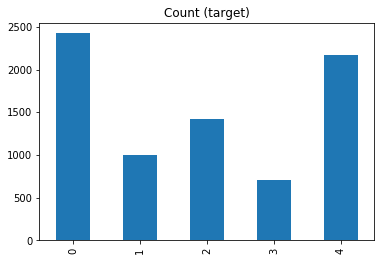

In [117]:
target_count = training_file_names.label.value_counts().sort_index()
df_classes = dict()
for keys, values in target_count.items():
    print('Class', keys, ': ', values)
    df_classes[keys] = training_file_names[training_file_names['label'] == keys]

print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')
plt.show()

In [119]:
# Class count
count_class_0 = training_file_names.label.value_counts()[0]

Random over-sampling:
4    2424
3    2424
2    2424
1    2424
0    2424
Name: label, dtype: int64


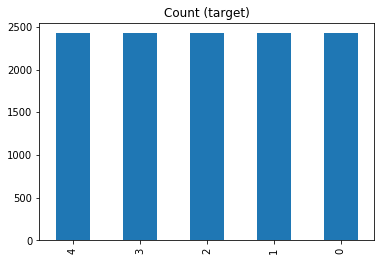

In [120]:
df_classes_over = dict()
training_file_names_over = pd.DataFrame()
for key in df_classes:
    df_classes_over[key]= df_classes[key].sample(count_class_0, replace=True)
    training_file_names_over = pd.concat([training_file_names_over, df_classes_over[key]], axis=0)
#training_file_names_over = pd.concat([df_class_0, df_class_1_over, df_class_2_over, df_class_3_over, df_class_4_over], axis=0)

print('Random over-sampling:')
print(training_file_names_over.label.value_counts())
training_file_names_over.label.value_counts().plot(kind='bar', title='Count (target)')
plt.show()

In [121]:
training_file_names_over = training_file_names_over.sample(frac=1).reset_index(drop=True)
display(training_file_names_over.head())
training_file_names_over.shape

,filename,ind,label
0,041_S_4051_S194895_T1_brain_mni305.nii,041_S_4051_194895,2
1,136_S_0426_S14581_T1_brain_mni305.nii,136_S_0426_14581,1
2,137_S_4631_S464254-T1_T1_brain_mni305.nii,137_S_4631_464254,3
3,020_S_1288_S145793_T1_brain_mni305.nii,020_S_1288_145793,0
4,007_S_1304_S39694-T1_T1_brain_mni305.nii,007_S_1304_39694,1


(12120, 3)

In [123]:
if not os.path.exists('../data'):
    os.makedirs('../data')

training_file_names_over.to_csv('../data/training_file_names_over.csv')
testing_file_names.to_csv('../data/testing_file_names.csv')
validation_file_names.to_csv('../data/validation_file_names.csv')

In [124]:
def write_tfrecords(save_filename, file_names, min_, max_ , dim=None, cut=None):
    '''
    raveling all three dimensions and normalizing every entry
    '''
    i=0
    writer = tf.compat.v1.python_io.TFRecordWriter(save_filename)
    for index, row in file_names.iterrows():
        filename = row['filename']
        label = int(row['label'])
        name = str.encode(row['ind'])
        try:
            image_ = nib.load('data/'+filename)
            im = image_.get_data()
            if dim:
                if dim=="x":
                    im = crop_image[cut,:,:]
                elif dim=="y":
                    im = crop_image[:,cut,:]
                elif dim=="z":
                    im = crop_image[:,:,cut]
            normalized_im = (im.ravel()-min_)/(max_+0.0001-min_)
            feature = {'label': _int64_feature(label),
                   'image': _float_feature(normalized_im),
                     'name': _bytes_feature(name)}
            # Create an example protocol buffer - Protocol buffers are a cross-platform, 
            #    cross-language library for efficient serialization of structured data.
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            # Serialize to string and write on the file
            writer.write(example.SerializeToString())
            i+=1
            if i%500==0:
                print('i: ',i)
        except:
            continue

    writer.close()

In [143]:
write_tfrecords('../data/training_flat_256_3d.tfrecords', training_file_names_over, min_flat, max_flat)
write_tfrecords('../data/testing_flat_256_3d.tfrecords', testing_file_names, min_flat, max_flat)
write_tfrecords('../data/validation_flat_256_3d.tfrecords', validation_file_names, min_flat, max_flat)

In [144]:
write_tfrecords('../data/training_flat_x_156_full_dataset.tfrecords',
                training_file_names_over, min_flat_x, max_flat_x, "x", 127)
write_tfrecords('../data/testing_flat_x_156_full_dataset.tfrecords',
                testing_file_names, min_flat_x, max_flat_x, "x", 127)
write_tfrecords('../data/validation_flat_x_156_full_dataset.tfrecords',
                validation_file_names, min_flat_x, max_flat_x, "x", 127)

In [145]:
write_tfrecords('../data/training_flat_y_156_full_dataset.tfrecords',
                training_file_names_over, min_flat_y, max_flat_y, "y", 127)
write_tfrecords('..data/testing_flat_y_156_full_dataset.tfrecords',
                testing_file_names, min_flat_y, max_flat_y, "y", 127)
write_tfrecords('..data/validation_flat_y_156_full_dataset.tfrecords',
                validation_file_names, min_flat_y, max_flat_y, "y", 127)

NotFoundError: ..data/testing_flat_y_156_full_dataset.tfrecords; No such file or directory

In [ ]:
write_tfrecords('..data/training_flat_z_156_full_dataset.tfrecords',
                training_file_names_over, min_flat_z, max_flat_z, "z", 127)
write_tfrecords('..data/testing_flat_z_156_full_dataset.tfrecords',
                testing_file_names, min_flat_z, max_flat_z, "z", 127)
write_tfrecords('..data/validation_flat_z_156_full_dataset.tfrecords',
                validation_file_names, min_flat_z, max_flat_z, "z", 127)